# Process :
    - DATA PREPROCESS 
    - SELECT MODELS 
    - FEATURE ENGINEERING 
       - Add new features : AVG price/kilometer/powerPS
    - PREDICTION ENSEMBLE 

#  Model :  
    - * Linear regression for every car group (barnd)
    - Modeling for different sub group data set  
# =========================================================

In [2]:
# Load basics library 

import pandas as pd, numpy as np
%matplotlib inline
%pylab inline
import seaborn  as sns 
import pylab as pl
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


# * 0 ) Data Preprocess 

In [3]:
# load car csv 

df = pd.read_csv('/Users/yennanliu/Kaggle.com_mini_project/used-cars-database/autos.csv' ,encoding = "ISO-8859-1" )

In [4]:
df = df.drop(['nrOfPictures','postalCode','abtest'], axis=1)

- Drop columns :  nrOfPictures, postalCode, abtest 
   - nrOfPictures  are all 0 
   - postalCode is not related to car price apparently
   - abtest has no description

In [5]:
df = df[(df.price < 150000) & (df.price > 100) ]

- Drop extreme big / small / unusual price data points

In [6]:
df = df[(df.yearOfRegistration > 1900) & (df.yearOfRegistration <= 2016) ]

- Remove no sense yearOfRegistration data points , > 1900 for possible earlist register time, and <= 2016 based on lastSeen column

In [7]:
df = df[(df.powerPS > 50) & (df.powerPS < 1000) ]

In [8]:
# transform string to timestamp 

df.dateCrawled = pd.to_datetime(df.dateCrawled)
df.dateCreated = pd.to_datetime(df.dateCreated)
df.lastSeen = pd.to_datetime(df.lastSeen)

In [9]:
# create new feature : "time_online" by differences in days among lastseen and datesreated

df['time_online'] = (df.lastSeen - df.dateCreated).apply(lambda x: int(x.days))

In [10]:
# CHECK features correlation

corr = df.corr()
corr.loc[:,'price'].abs().sort_values(ascending=False)[1:]

powerPS                0.577120
kilometer              0.448864
yearOfRegistration     0.391513
time_online            0.127522
monthOfRegistration    0.042002
Name: price, dtype: float64

In [11]:
selected_feature = ['price',
                    'powerPS',
                    'kilometer',
                    'yearOfRegistration',
                    'time_online']
                    #'monthOfRegistration']

In [12]:
selected_feature

['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']

## 0-1 ) help function 

In [13]:
#  help function 

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error


def sample_split(data):
    #data =  data[selected_feature]
    relevent_cols = list(data)
    autos=data.values.astype(float)             
    Y = autos[:,0]
    X = autos[:,1:]
    test_size = .3
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state = 3)
    return X_train, X_test, y_train, y_test


def reg_analysis(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    #Calculate Variance score
    Variance_score = explained_variance_score(y_test, prediction)
    print ('Variance score : %.2f' %Variance_score)
    #Mean Absolute Error
    MAE = mean_absolute_error(y_test, prediction)
    print ('Mean Absolute Error : %.2f' %MAE)
    #Root Mean Squared Error
    RMSE = mean_squared_error(y_test, prediction)**0.5
    print ('Mean Squared Error : %.2f' %RMSE)
    #R² score, the coefficient of determination
    r2s = r2_score(y_test, prediction)
    print ('R2  score : %.2f' %r2s)
    return model
    

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

## 0-2) test / train data prepare 

In [16]:
X_train, X_test, y_train, y_test = sample_split(df[selected_feature])

# 1) Modeling 

## 1-1) Linear regression 

In [17]:
# Linear model 

from sklearn import linear_model

model = linear_model.LinearRegression()
print ('Linear Regression')
reg_analysis(model,X_train, X_test, y_train, y_test)

Linear Regression
Variance score : 0.55
Mean Absolute Error : 3199.31
Mean Squared Error : 5576.08
R2  score : 0.55


//anaconda/envs/g_dash/lib/python3.4/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [19]:
df[selected_feature].head()

,price,powerPS,kilometer,yearOfRegistration,time_online
1,18300,190,125000,2011,14
2,9800,163,125000,2004,22
3,1500,75,150000,2001,0
4,3600,69,90000,2008,6
5,650,102,150000,1995,2


In [28]:
selected_feature

['price', 'powerPS', 'kilometer', 'yearOfRegistration', 'time_online']

powerPS
linear fit  score : 0.333067964585


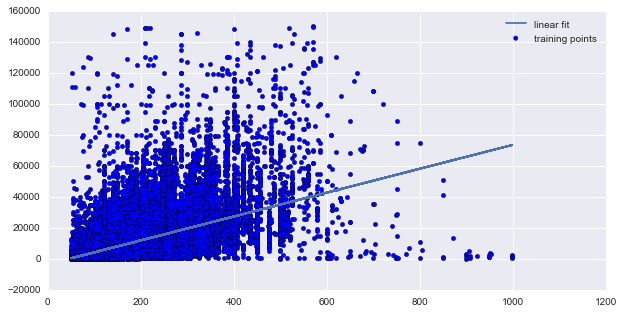

kilometer
linear fit  score : 0.201479099372


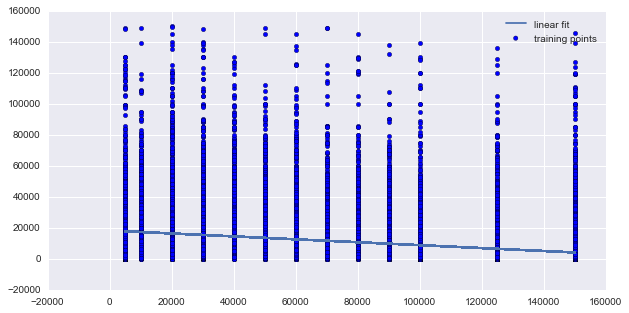

yearOfRegistration
linear fit  score : 0.153282387833


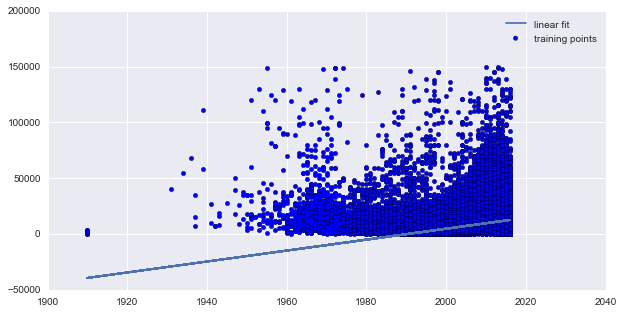

time_online
linear fit  score : 0.0162618758222


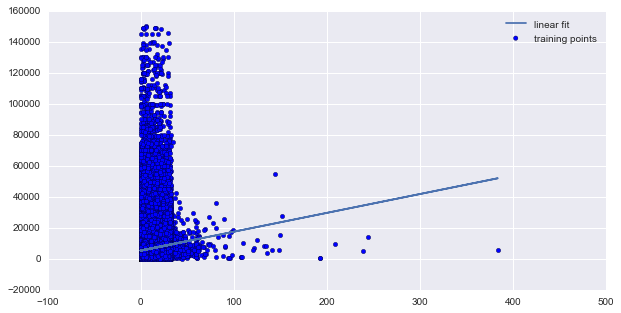

In [31]:
#  prdeict / real data plots 

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

for feature in selected_feature[1:]:
    
    print (feature)
    X_ = df[[feature]].values
    y_ = df[['price']].values

    # linear fit 
    pr = LinearRegression()
    pr.fit(X_,y_)
    y_linear_fit = pr.predict(X_)
    print ('linear fit  score :', pr.score(X_,y_))
    
    # visualize 
    plt.figure(figsize=(10,5))
    plt.scatter(X_,y_, label = 'training points')
    plt.plot(X_,y_linear_fit, label = 'linear fit',linestyle = '-')
    plt.legend(loc='upper right')
    plt.show()

## 1-2) linear SVR 

In [29]:
# linear SVR

#from sklearn.svm import SVR
# run linear SVR first ( kernel = linear)

from sklearn.svm import LinearSVR

model = LinearSVR()
print ('SVR')
reg_analysis(model,X_train, X_test, y_train, y_test)

SVR
Variance score : 0.38
Mean Absolute Error : 6440.36
Mean Squared Error : 8154.49
R2  score : 0.04


LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

powerPS


//anaconda/envs/g_dash/lib/python3.4/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR linear fit  score : -2.91618386624


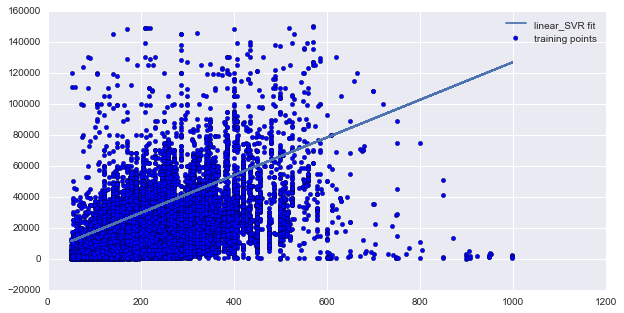

kilometer
SVR linear fit  score : -3745940.08854


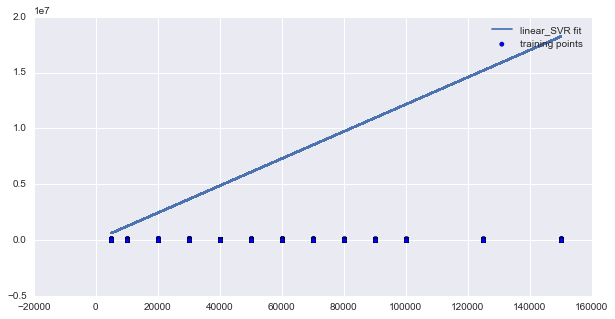

yearOfRegistration
SVR linear fit  score : -862.958361571


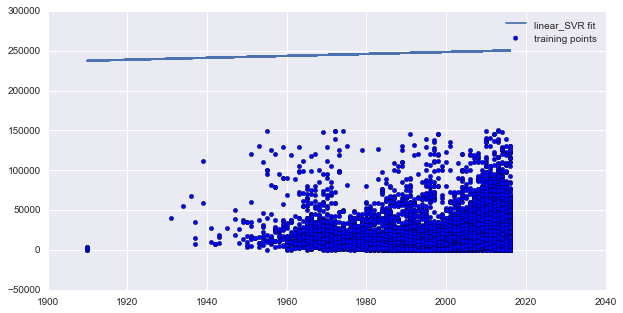

time_online
SVR linear fit  score : 0.0162618758222


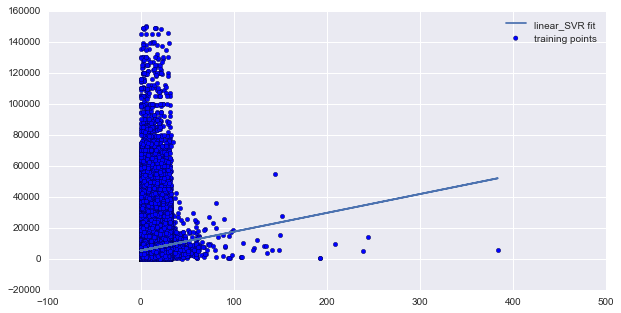

In [32]:
#  prdeict / real data plots

for feature in selected_feature[1:]:
    
    print (feature)
    X_ = df[[feature]].values
    y_ = df[['price']].values

    # linear fit 
    linear_SVR = LinearSVR()
    linear_SVR.fit(X_,y_)
    y_linear_fit = pr.predict(X_)
    print ('SVR linear fit  score :', pr.score(X_,y_))
    
    # visualize 
    plt.figure(figsize=(10,5))
    plt.scatter(X_,y_, label = 'training points')
    plt.plot(X_,y_linear_fit, label = 'linear_SVR fit',linestyle = '-')
    plt.legend(loc='upper right')
    plt.show()

## 1-3) decision tree

In [35]:
# Decision tree

from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
print ('Decision tree')
reg_analysis(model,X_train, X_test, y_train, y_test)

Decision tree
Variance score : 0.62
Mean Absolute Error : 2351.70
Mean Squared Error : 5170.95
R2  score : 0.61


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

powerPS
decision tree fit  score : -2.91618386624


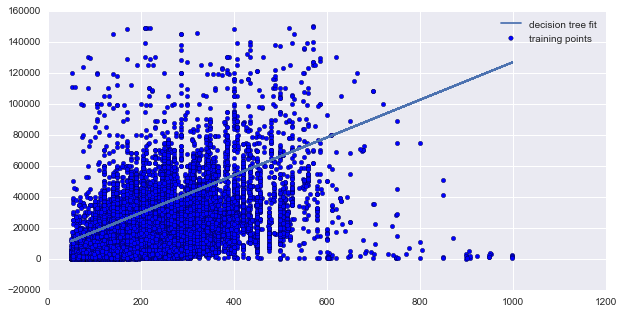

kilometer
decision tree fit  score : -3745940.08854


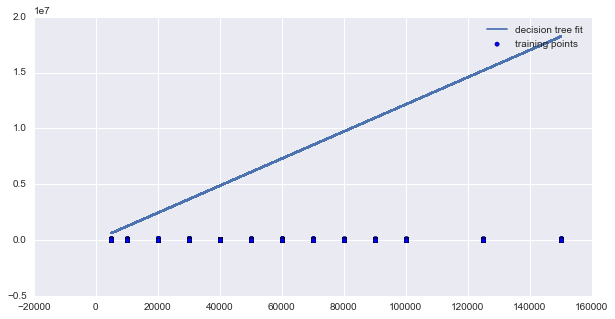

yearOfRegistration
decision tree fit  score : -862.958361571


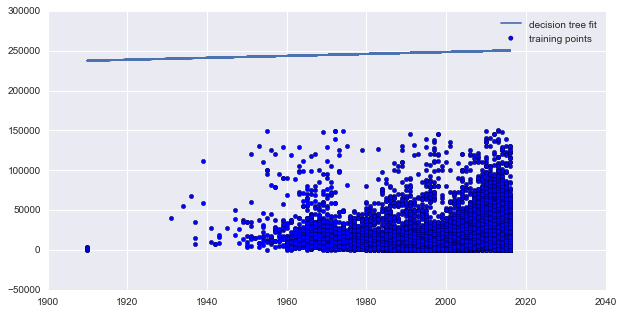

time_online
decision tree fit  score : 0.0162618758222


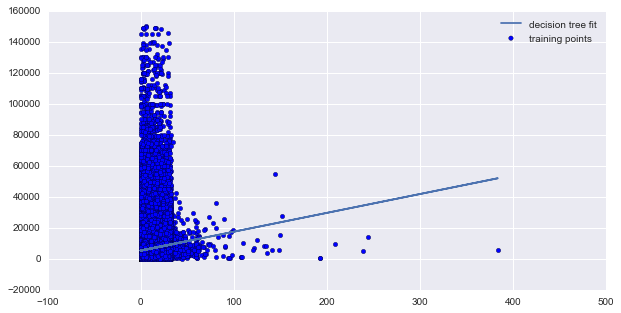

In [36]:
#  prdeict / real data plots 

for feature in selected_feature[1:]:
    
    print (feature)
    X_ = df[[feature]].values
    y_ = df[['price']].values

    # linear fit 
    tree_model = tree.DecisionTreeClassifier()
    tree_model.fit(X_,y_)
    y_tree_fit = pr.predict(X_)
    print ('decision tree fit  score :', pr.score(X_,y_))
    
    # visualize 
    plt.figure(figsize=(10,5))
    plt.scatter(X_,y_, label = 'training points')
    plt.plot(X_,y_tree_fit, label = 'decision tree fit',linestyle = '-')
    plt.legend(loc='upper right')
    plt.show()

## 1-4) random forest

In [44]:
# Random forest 

from sklearn.ensemble import RandomForestRegressor

random_forest_model = RandomForestRegressor()
print ('Random forest')
RandomForestRegressor_model = reg_analysis(random_forest_model,X_train, X_test, y_train, y_test)

Random forest
Variance score : 0.74
Mean Absolute Error : 1943.47
Mean Squared Error : 4199.95
R2  score : 0.74


In [50]:
# re-run model with new featured dataset 

X_train, X_test, y_train, y_test = sample_split(df[selected_feature])

#X_train

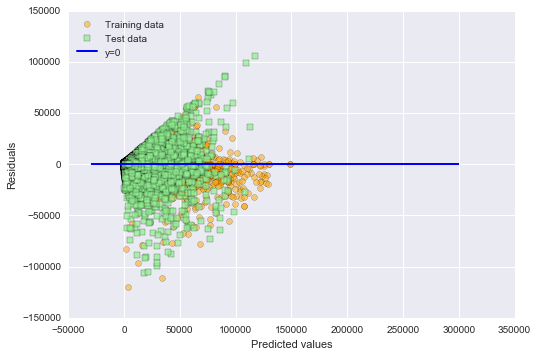

In [54]:
## since decision tree / ramdom forest works bad on single feature,
## here I plot error distribution between predict-true data instead of 
## single feature fitting plots as above

from sklearn.ensemble import RandomForestRegressor
random_forest_model = RandomForestRegressor()

# split train, test data 
X_train, X_test, y_train, y_test = sample_split(df[selected_feature])
# train model
random_forest_model.fit(X_train,y_train)
# predict 
y_train_pred = random_forest_model.predict(X_train)
y_test_pred = random_forest_model.predict(X_test)
# plots 
plt.scatter(y_train_pred,
           y_train_pred - y_train,
           c='orange',
           marker='o',
           s=35,
           alpha=0.5,
           label ='Training data')

plt.scatter(y_test_pred,
           y_test_pred - y_test,
           c='lightgreen',
           marker='s',
           s=35,
           alpha=0.7,
           label ='Test data')

plt.hlines(y=0,xmin=-30000,xmax=300000,lw=2,color='blue',label = "y=0")
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')

plt.show()

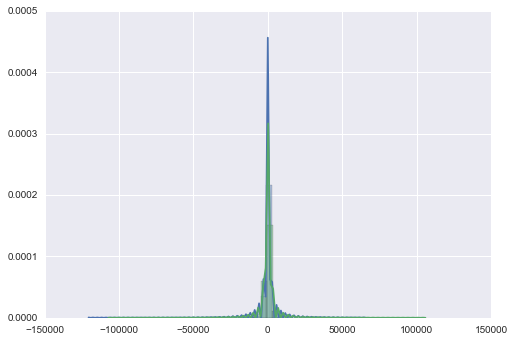

In [64]:
# error distribution foe train data 
sns.distplot(pd.DataFrame(y_train_pred - y_train))
# error distribution foe test data 
sns.distplot(pd.DataFrame(y_test_pred - y_test))